## Import

In [1]:
# Import of basic packages
import numpy as np
import pandas as pd
import operator
import warnings

warnings.filterwarnings('ignore')

# Import of chart packages
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import altair as alt

# Import of machine learning metric packages
from sklearn.metrics import f1_score, classification_report, confusion_matrix, mean_squared_error, r2_score, accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, fbeta_score
from sklearn import metrics

# Import of preprossesor packages
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, LabelBinarizer, PolynomialFeatures

# Import of machine learning packages
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingRegressor, StackingClassifier, AdaBoostClassifier
#from xgboost import XGBClassifier
from sklearn.svm import SVC

# Set random seed 
RSEED = 0

## Style

In [2]:
pd.set_option('display.max_columns', None)

## Load

In [3]:
# Load csv
df = pd.read_csv('data/train.csv')
df.head(3)

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN,260.0
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO,20.0
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06.45.00,ATA,TU 32AIMN,0.0


## Explore data analysis

In [4]:
# EDA info & describe
info = pd.concat([
df.dtypes.to_frame().T,
df.mean(numeric_only=True).to_frame().T,
df.std(numeric_only=True).to_frame().T,
df.min(numeric_only=True).to_frame().T,
df.quantile(0.25, numeric_only=True).to_frame().T,
df.quantile(0.5, numeric_only=True).to_frame().T, 
df.quantile(0.75, numeric_only=True).to_frame().T,
df.max(numeric_only=True).to_frame().T,], ignore_index=True).applymap(lambda x: round(x, 1) if isinstance(x, (int, float)) else x)

info.insert(0, 'statistic', ['dtype', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'])
info

,statistic,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target
0,dtype,object,object,object,object,object,object,object,object,object,float64
1,mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.7
2,std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117.1
3,min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
5,50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0
6,75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.0
7,max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3451.0


In [5]:
# EDA duplicates
duplicates = df.duplicated().sum()
duplicate_percentage = round((duplicates / df.shape[0]) * 100, 1)
df[df.duplicated(keep=False)].head(10)

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target


In [6]:
# EDA NaNs
missing = pd.DataFrame(df.isnull().sum(), columns=['Amount'])
missing['Percentage'] = round((missing['Amount']/df.shape[0]) * 100, 1)
missing[missing['Amount'] != 0]

,Amount,Percentage


In [7]:
# EDA shape
print('Number of rows and columns: ',df.shape)
print('-'*50)
pd.concat([df.head(3), df.tail(3)]).reset_index(drop=True)

Number of rows and columns:  (107833, 10)
--------------------------------------------------


,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN,260.0
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO,20.0
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06.45.00,ATA,TU 32AIMN,0.0
3,train_id_107830,2018-11-07,SGT 0000,TUN,TUN,2018-11-07 05:00:00,2018-11-07 12.50.00,SCH,TU 736IOK,0.0
4,train_id_107831,2018-01-23,UG 0010,TUN,DJE,2018-01-23 18:00:00,2018-01-23 18.45.00,ATA,TU CR9ISA,0.0
5,train_id_107832,2018-11-13,UG 0002,TUN,DJE,2018-11-13 06:15:00,2018-11-13 07.05.00,SCH,TU CR9ISA,0.0


In [8]:
# EDA Uniques
unique_counts = pd.DataFrame(df.nunique(), columns=['Amount']).sort_values('Amount', ascending=False).T
unique_counts

,ID,STA,STD,FLTID,DATOP,target,DEPSTN,ARRSTN,AC,STATUS
Amount,107833,85136,81697,1861,1011,968,132,128,68,5


In [9]:
df.head(10)

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN,260.0
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO,20.0
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06.45.00,ATA,TU 32AIMN,0.0
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17.00.00,ATA,TU 736IOK,0.0
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15.50.00,ATA,TU 320IMU,22.0
5,train_id_5,2016-01-17,TU 0283,TLS,TUN,2016-01-17 16:20:00,2016-01-17 18.15.00,ATA,TU 736IOP,53.0
6,train_id_6,2016-01-18,TU 0514,TUN,BCN,2016-01-18 07:15:00,2016-01-18 09.00.00,ATA,TU 32AIMH,10.0
7,train_id_7,2016-01-18,TU 0716,TUN,ORY,2016-01-18 07:35:00,2016-01-18 09.55.00,ATA,TU 32AIMI,15.0
8,train_id_8,2016-01-18,TU 0752,TUN,FCO,2016-01-18 07:40:00,2016-01-18 09.00.00,ATA,TU 32AIMC,16.0
9,train_id_9,2016-01-18,TU 0996,TUN,NCE,2016-01-18 07:45:00,2016-01-18 09.15.00,ATA,TU 31AIMK,21.0


In [10]:
# Get unique departure airports
df["DEPSTN"].unique()

array(['CMN', 'MXP', 'TUN', 'DJE', 'TLS', 'IST', 'ORY', 'MIR', 'BRU',
       'ABJ', 'VCE', 'AMS', 'FRA', 'BCN', 'JED', 'ALG', 'LIS', 'SXB',
       'LYS', 'OUA', 'LGW', 'BEY', 'NCE', 'OPO', 'MRS', 'DUS', 'SFA',
       'FCO', 'CDG', 'NKC', 'NTE', 'ZRH', 'GVA', 'OUD', 'MUC', 'SXF',
       'HAM', 'NDR', 'NBE', 'CAI', 'BEG', 'VIE', 'ORN', 'MAD', 'TOE',
       'BKO', 'DKR', 'KGL', 'BLQ', 'MLA', 'AHU', 'LHR', 'BOD', 'PRG',
       'LJU', 'SVO', 'MED', 'BUD', 'ARN', 'CPH', 'CRL', 'OST', 'TNG',
       'GAF', 'NAP', 'BRQ', 'OSR', 'YUL', 'NIM', 'TMR', 'JIB', 'CGN',
       'EBL', 'GAE', 'BJA', 'AYT', 'RAK', 'LFW', 'LIL', 'PMO', 'FBM',
       'TBJ', 'PSA', 'KRT', 'GNB', 'CZL', 'MVB', 'VNO', 'ESB', 'LBV',
       'CKY', 'LED', 'KSC', 'BTS', 'AMM', 'OTP', 'TRN', 'IEV', 'HBE',
       'CAG', 'KBP', 'ATH', 'SKG', 'ADB', 'DSS', 'DOH', 'COO', 'LUX',
       'FIH', 'BYJ', 'KEF', 'EBM', 'BDS', 'AAL', 'VKO', 'AAE', 'BRI',
       'VRN', 'SKX', 'HAJ', 'BLL', 'TLL', 'VOG', 'LAD', 'GHA', 'KTW',
       'SJJ', 'KRR',

In [11]:
# Get unique arrival airports
df["ARRSTN"].unique()

array(['TUN', 'IST', 'NTE', 'ALG', 'BCN', 'ORY', 'FCO', 'NCE', 'MRS',
       'MED', 'FRA', 'BRU', 'DJE', 'LYS', 'CMN', 'BEG', 'OUA', 'GVA',
       'MXP', 'BEY', 'MAD', 'JED', 'ABJ', 'VIE', 'MLA', 'BLQ', 'SFA',
       'LIS', 'LHR', 'CDG', 'MIR', 'CAI', 'DUS', 'HAM', 'NBE', 'ZRH',
       'AMS', 'NDR', 'TLS', 'VCE', 'SXB', 'MUC', 'LGW', 'CRL', 'ORN',
       'DKR', 'BOD', 'SXF', 'LJU', 'OST', 'NKC', 'BKO', 'TOE', 'AHU',
       'YUL', 'PRG', 'CPH', 'ARN', 'OUD', 'BRQ', 'GAF', 'JIB', 'BUD',
       'OPO', 'KGL', 'NIM', 'SVO', 'LIL', 'OSR', 'EBL', 'TNG', 'PSA',
       'CGN', 'AYT', 'GAE', 'NAP', 'BJA', 'KRT', 'LFW', 'TBJ', 'PMO',
       'TMR', 'FBM', 'RAK', 'GNB', 'ESB', 'CZL', 'LBV', 'KSC', 'CKY',
       'AMM', 'LED', 'BTS', 'MVB', 'HBE', 'OTP', 'CAG', 'VNO', 'TRN',
       'ATH', 'ADB', 'SKG', 'BYJ', 'DSS', 'COO', 'IEV', 'LUX', 'KBP',
       'DOH', 'FIH', 'EBM', 'BDS', 'VKO', 'AAE', 'BLL', 'HAJ', 'BRI',
       'CTA', 'VRN', 'SKX', 'VOG', 'BGY', 'LAD', 'KRR', 'SJJ', 'GHA',
       'RTM', 'TPS']

In [12]:
# Get dataframe for delayed flights
df_delayed = df.copy()
df_delayed = df_delayed[df_delayed["target"] > 0]
df_delayed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69665 entries, 0 to 107675
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      69665 non-null  object 
 1   DATOP   69665 non-null  object 
 2   FLTID   69665 non-null  object 
 3   DEPSTN  69665 non-null  object 
 4   ARRSTN  69665 non-null  object 
 5   STD     69665 non-null  object 
 6   STA     69665 non-null  object 
 7   STATUS  69665 non-null  object 
 8   AC      69665 non-null  object 
 9   target  69665 non-null  float64
dtypes: float64(1), object(9)
memory usage: 5.8+ MB


General statistics of target:
 count    107833.000000
mean         48.733013
std         117.135562
min           0.000000
25%           0.000000
50%          14.000000
75%          43.000000
max        3451.000000
Name: target, dtype: float64


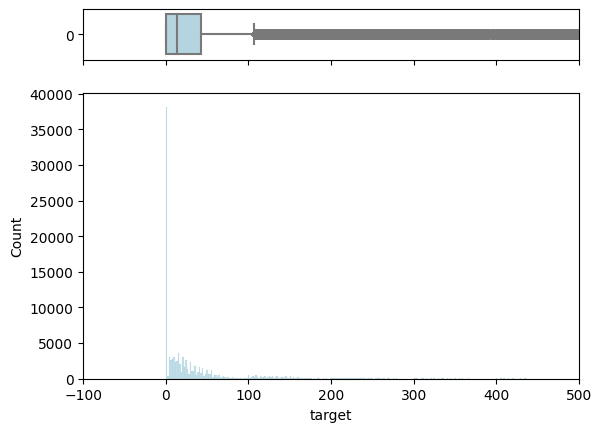

In [13]:
# Overview of target distribution
print("General statistics of target:\n", (df['target']).describe())

# Creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Assigning a graph to each ax
sns.boxplot(df["target"], orient="h", ax=ax_box, color='lightblue')
sns.histplot(data=df, x="target", ax=ax_hist, color='lightblue')

# Remove x axis name for the boxplot
ax_box.set(xlabel='')
ax_box.set_xlim([-100, 500])
plt.show()

General statistics of target (of delayed flights):
 count    69665.000000
mean        75.432814
std        138.650946
min          1.000000
25%         15.000000
50%         30.000000
75%         74.000000
max       3451.000000
Name: target, dtype: float64


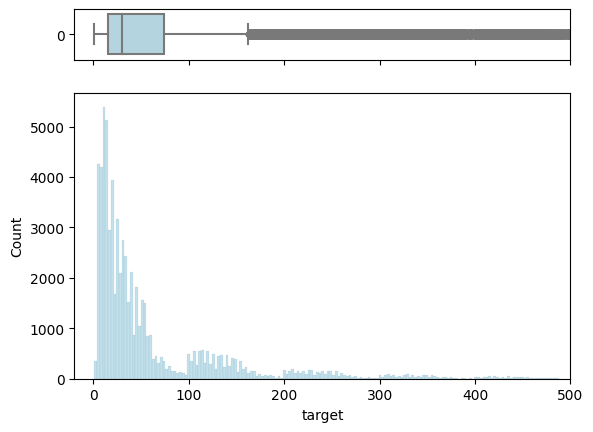

In [14]:
# Overview of target distribution (of delayed flights)
print("General statistics of target (of delayed flights):\n", (df_delayed['target']).describe())

# Creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Assigning a graph to each ax
sns.boxplot(df_delayed["target"], orient="h", ax=ax_box, color='lightblue')
sns.histplot(data=df_delayed, x="target", ax=ax_hist, color='lightblue')

# Remove x axis name for the boxplot
ax_box.set(xlabel='')
ax_box.set_xlim([-20, 500])
plt.show()

## Data cleaning

In [15]:
# Clean column names
df.columns = df.columns.str.replace(' ','_')
df.columns = df.columns.str.lower()

Feature 'ac' holds information about the model of the airplane. Extracting and converting the information.

In [16]:
df['airplane_model'] = df['ac'].str[3:6]
df.head()

,id,datop,fltid,depstn,arrstn,std,sta,status,ac,target,airplane_model
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN,260.0,32A
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO,20.0,31B
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06.45.00,ATA,TU 32AIMN,0.0,32A
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17.00.00,ATA,TU 736IOK,0.0,736
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15.50.00,ATA,TU 320IMU,22.0,320


In [17]:
# EDA Uniques
unique_counts = pd.DataFrame(df.nunique(), columns=['Amount']).sort_values('Amount', ascending=False).T
unique_counts

,id,sta,std,fltid,datop,target,depstn,arrstn,ac,airplane_model,status
Amount,107833,85136,81697,1861,1011,968,132,128,68,16,5


In [18]:
set(df['airplane_model'])

{'319',
 '31A',
 '31B',
 '320',
 '321',
 '32A',
 '332',
 '343',
 '345',
 '733',
 '734',
 '736',
 '738',
 'AT7',
 'CR9',
 'M87'}

In [19]:
replacement_dict = {
    '31A': 'Airbus',
    '31B': 'Airbus',
    '320': 'Airbus',
    '321': 'Airbus',
    '32A': 'Airbus',
    '332': 'Airbus',
    '343': 'Airbus',
    '345': 'Airbus',
    '733': 'Boeing',
    '734': 'Boeing',
    '736': 'Boeing',
    'AT7': 'ATR',
    'CR9': 'Bombardier'
}

df['producer'] = df['airplane_model']

# Replace values in the 'purpose' column
df['producer'] = df['producer'].replace(replacement_dict)


In [20]:
df.head()

,id,datop,fltid,depstn,arrstn,std,sta,status,ac,target,airplane_model,producer
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN,260.0,32A,Airbus
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO,20.0,31B,Airbus
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06.45.00,ATA,TU 32AIMN,0.0,32A,Airbus
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17.00.00,ATA,TU 736IOK,0.0,736,Boeing
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15.50.00,ATA,TU 320IMU,22.0,320,Airbus


In [21]:
df['airline_1'] = df['fltid'].str[0:2]
df.head()

,id,datop,fltid,depstn,arrstn,std,sta,status,ac,target,airplane_model,producer,airline_1
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN,260.0,32A,Airbus,TU
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO,20.0,31B,Airbus,TU
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06.45.00,ATA,TU 32AIMN,0.0,32A,Airbus,TU
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17.00.00,ATA,TU 736IOK,0.0,736,Boeing,TU
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15.50.00,ATA,TU 320IMU,22.0,320,Airbus,TU


In [22]:
set(df['airline_1'])

{'12',
 '20',
 '6Y',
 'A ',
 'AO',
 'AT',
 'AU',
 'C ',
 'D4',
 'DA',
 'GJ',
 'IN',
 'PR',
 'SG',
 'TU',
 'UG',
 'UH',
 'WK',
 'X9'}

In [23]:
df['airline_2'] = df['ac'].str[0:2]
df.head()

,id,datop,fltid,depstn,arrstn,std,sta,status,ac,target,airplane_model,producer,airline_1,airline_2
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN,260.0,32A,Airbus,TU,TU
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO,20.0,31B,Airbus,TU,TU
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06.45.00,ATA,TU 32AIMN,0.0,32A,Airbus,TU,TU
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17.00.00,ATA,TU 736IOK,0.0,736,Boeing,TU,TU
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15.50.00,ATA,TU 320IMU,22.0,320,Airbus,TU,TU


In [24]:
set(df['airline_2'])

{'5K',
 '5M',
 '6P',
 'BJ',
 'D4',
 'GJ',
 'GW',
 'OL',
 'PS',
 'QS',
 'TU',
 'UG',
 'UJ',
 'X9'}

In [25]:
df.head()

,id,datop,fltid,depstn,arrstn,std,sta,status,ac,target,airplane_model,producer,airline_1,airline_2
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN,260.0,32A,Airbus,TU,TU
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO,20.0,31B,Airbus,TU,TU
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06.45.00,ATA,TU 32AIMN,0.0,32A,Airbus,TU,TU
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17.00.00,ATA,TU 736IOK,0.0,736,Boeing,TU,TU
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15.50.00,ATA,TU 320IMU,22.0,320,Airbus,TU,TU


Load airpots data set and clean. 

Merge data sets based on airport short handle. 

In [26]:
# Add columns with weekdays

# add weekday to std

date = 'std'
wd = '_wd'
idx = 6

df[date] = pd.to_datetime(df[date], format='%Y-%m-%d %H:%M:%S')
df.insert(loc=idx, column=date+wd, value=df[date].dt.strftime('%a')) # insert weekday in new column right after std (position 6)

# add weekday to std

date = 'std'
wd = '_wd'
idx = 6

df[date] = pd.to_datetime(df[date], format='%Y-%m-%d %H:%M:%S')
df.insert(loc=idx, column=date+wd, value=df[date].dt.strftime('%a')) # insert weekday in new column right after std (position 6)



# add weekday to sta (different time format with "." instead of ":")

date = 'sta'
wd = '_wd'
idx = 8

df[date] = pd.to_datetime(df[date], format='%Y-%m-%d %H.%M.%S')
df.insert(loc=idx, column=date+wd, value=df[date].dt.strftime('%a')) # insert weekday in new column right after std (position 8)

df.head(3)

ValueError: cannot insert std_wd, already exists

Geo-encoding of airports

In [ ]:
# Load csv
df_airports = pd.read_csv('data/airports.csv')
df_airports.columns = ['id', 'name', 'city', 'country', 'short', 'rubbish_6', 'latitude', 'longitude', 'rubbish_1', 'rubbish_2', 'rubbish_3', 'rubbish_4', 'type', 'rubbish_5']
df_airports = df_airports.drop(['id', 'name', 'rubbish_1', 'rubbish_2', 'rubbish_3', 'rubbish_4', 'rubbish_5', 'rubbish_6', 'type'], axis=1)
df_airports = df_airports.dropna(subset=['short'])
df_airports.head(3)


,city,country,short,latitude,longitude
0,Pitt Meadows,Canada,\N,49.216099,-122.709999
1,Blida,Algeria,\N,36.503601,2.814170
2,Bou Saada,Algeria,\N,35.332500,4.206390


In [ ]:
df = df.merge(df_airports, left_on='depstn', right_on='short', how='left', suffixes=('', '_dep'))

# Merge based on arrival station
df = df.merge(df_airports, left_on='arrstn', right_on='short', how='left', suffixes=('', '_arr'))

# Rename columns for clarity
df = df.rename(columns={
    'city': 'city_dep',
    'country': 'country_dep',
    'latitude': 'latitude_dep',
    'longitude': 'longitude_dep'
})

df.head(3)


,id,datop,fltid,depstn,arrstn,std,std_wd,sta,status,ac,target,airplane_model,producer,airline_1,airline_2,city_dep,country_dep,short,latitude_dep,longitude_dep,city_arr,country_arr,short_arr,latitude_arr,longitude_arr
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,Sun,2016-01-03 12.55.00,ATA,TU 32AIMN,260.0,32A,Airbus,TU,TU,Casablanca,Morocco,CMN,33.367500,-7.58997,Tunis,Tunisia,TUN,36.851002,10.2272
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,Wed,2016-01-13 16.55.00,ATA,TU 31BIMO,20.0,31B,Airbus,TU,TU,Milano,Italy,MXP,45.630600,8.72811,Tunis,Tunisia,TUN,36.851002,10.2272
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,Sat,2016-01-16 06.45.00,ATA,TU 32AIMN,0.0,32A,Airbus,TU,TU,Tunis,Tunisia,TUN,36.851002,10.22720,Istanbul,Turkey,IST,40.976898,28.8146


## Feature engineering

## Splitting data for testing 

## Trainining the model

## Evaluation

## Validation

## Packaging